In [2]:
import pandas as pd 
import numpy as np 
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science', 'grid', 'retro'])

In [8]:
class TransportCoefficients:
    def __init__(self, D, S, V):
        self.D = D # np.empty_like(x) # calcD(DIN, x)
        self.S = S # np.empty_like(x)
        self.V = V # np.empyt_like(x)

class Boundaries: 
    def __init__(self, FluxIn, u_edge): 
        self.fluxin = FluxIn 
        self.u_edge = u_edge

def pedestal_ode(x, u, coeffs: TransportCoefficients,  bcs:Boundaries):
    dudx = np.gradient(u, x)
    dudx[0] = (bcs.fluxin - coeffs.V[0]*u[0])/coeffs.D[0] # I DON'T THINK THIS IS CORRECT
    dudx[-1] = (u[-1] - u[-2])/(x[-1] - x[-2])

    flux = coeffs.D * dudx + coeffs.V * u
    flux[0] = bcs.fluxin

    dudt = np.gradient(flux, x) + coeffs.S
    dudt[0] = (flux[1] - flux[0]) / (x[1] - x[0]) # IS THIS NECSESARY?
    dudt[-1] = 0.0
    return dudt

def solve_pde(x, u0, coef, bcs, tinterval: list[float]): 
    ode_to_handle = lambda t, y: pedestal_ode(x, y, coef, bcs)
    sol = solve_ivp(ode_to_handle, tinterval, u0, method='RK45', rtol=1E-5)
    return sol.y# [:, -1]

def mtanh(r,h1, h0, s, p, w ): 
    # h1, h0, s, p, w = ped height, offset, slope, position, width\n",
    x = (p - r) / (w / 2.0)
    return (h1 - h0) / 2.0 * ( ((1 + s*x)*np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)) + 1) + h0

norm_pdf = lambda _x, mu, sigma: (1.0 / np.sqrt(np.pi*2*sigma**2)) * np.exp(-(_x-mu)**2 / (2*sigma**2))

In [9]:
df = pd.read_csv('/home/kitadam/EuroFUSION/2024/transport_coupling/sankt_sven_final/docs/FINAL_DATABASE.csv')
shot_num, n_prof_height, n_prof_slope, n_prof_position, n_prof_width, t_prof_height, t_prof_slope, t_prof_position, t_prof_width = df.iloc[0].T[['shot', 'nepedheight10^19(m^-3)','neinnerslope','neposition(psiN)','Nepedestalwidth(psiN%)','Tepedheight(keV)','Teinnerslope','Teposition(psiN)','Tepedestalwidth(psiN%)']].T.values
ne_params, te_params = [n_prof_height, n_prof_slope, n_prof_position, n_prof_width], [t_prof_height, t_prof_slope, t_prof_position, t_prof_width]

In [21]:
NX = 200
x = np.linspace(0.9, 1.05, NX)
# n_prof_height, prof_slope, prof_position, prof_width = 3.4419810747067103,0.030139759552640658,0.9969544671849752,0.05960778316391867 # 2.77015220953408,0.10856566193018946,1.0121382125850138,0.14214093301620753

info = {}
for name, dset in zip(['density', 'temperature'], [ne_params, te_params]): 
    prof_height, prof_slope, prof_position, prof_width = dset
    # Flux in can be non-zero
    fluxin = - prof_height / 4.0 
    u_edge = 0.0
    bcs = Boundaries(fluxin, u_edge)

    u0 = mtanh(x, prof_height, u_edge, prof_slope, prof_position ,prof_width)  
    du0dx = np.gradient(u0, x)
    S = np.zeros(NX)

    D_interelm = abs(1.0 / du0dx)
    if name == 'temperature': 
        V_interelm = np.zeros_like(x)
    else: 
        V_interelm = 1.0 / u0

    coeffs_interelm = TransportCoefficients(D_interelm, S, V_interelm)

    V_intraelm = np.ones(NX)
    # V_intraelm[x>1.0] = n_prof_height
    example_d = norm_pdf(x, 1.0, prof_width / 2.0)
    D_intraelm = (example_d / (2.0*max(example_d)))*10.0 + D_interelm 
    coeffs_intraelm = TransportCoefficients(D_intraelm, S, V_intraelm)
    info[name] = [u0, coeffs_interelm, coeffs_intraelm, bcs]
    


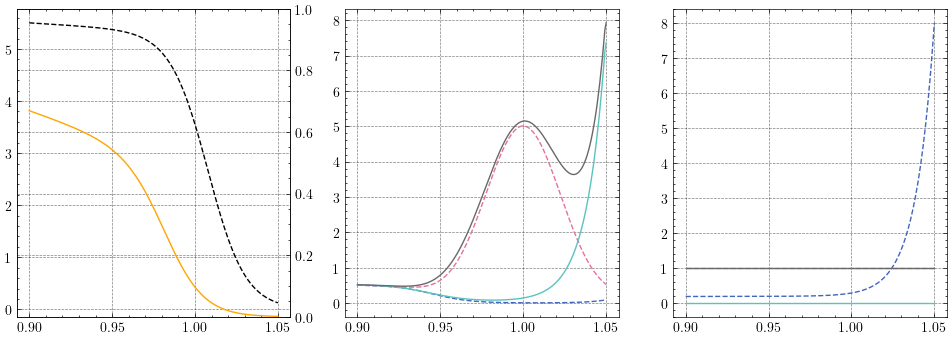

In [28]:

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for n, (name, sim_info) in enumerate(info.items()): 
    u0, coeffs_interelm, coeffs_intraelm, bcs = sim_info
    if name == 'density': 
        ls = '--'
        axs[0].plot(x, u0, label='Initial Condition', color='black', ls=ls)
        axs[0].set_yticks([0, 1, 2,3,4,5])
    else: 
        t_ax = axs[0].twinx()
        ls = None
        t_ax.plot(x, u0, color='orange', ls=ls)
        t_ax.set_ylim(0, 1)
        t_ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

        
    for n, _coef in enumerate([coeffs_interelm, coeffs_intraelm]):
        axs[1].plot(x, _coef.D, label='D(x)', ls=ls)
        axs[2].plot(x, _coef.V, label='V(x)', ls=ls)


plt.show()
